Proactive Learning with Emotion Detection in Non-Cooperative Discourse.

Copyright (C) 2022  Rigved Rakshit

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Introduction

This Jupyter notebook will perform exploratory data analysis on the dataset released by Ferracane et al. (2021).

# EDA

In [1]:
# Import the required libraries

import nltk
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import text2emotion as t2e       # Relative import

# Set options for pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_item', None)
pd.set_option('display.max_rows', None)

# Set options for matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

# Options for parallel execution
max_workers = 7

[nltk_data] Downloading package stopwords to /home/rr3369/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rr3369/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rr3369/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset

complete_data_with_duplicates = pd.read_csv('../data/expanded_with_features_annotated_questions_responses_gold.csv')
complete_data_without_duplicates = complete_data_with_duplicates.drop_duplicates(subset='qa_index')

In [3]:
# Calculate the number of tokens and sentences for questions and responses
# per discourse turn.

q_turn_count = complete_data_without_duplicates['q_text'].count()
q_sentence_count = q_token_count = 0

r_turn_count = complete_data_without_duplicates['r_text'].count()
r_sentence_count = r_token_count = 0

# Define the sentence and work token length functions
def sentence_token_length(text):
    return len(nltk.sent_tokenize(text))

def word_token_length(text):
    return len(nltk.word_tokenize(text))

q_text_list = complete_data_without_duplicates['q_text'].tolist()
r_text_list = complete_data_without_duplicates['r_text'].tolist()

# Use multiple processes to calculate the counts quickly
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(sentence_token_length, q_text_list))

q_sentence_count = np.sum(results)

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(word_token_length, q_text_list))

q_token_count = np.sum(results)

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(sentence_token_length, r_text_list))

r_sentence_count = np.sum(results)

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(word_token_length, r_text_list))

r_token_count = np.sum(results)

q_tokens_per_turn = q_token_count / q_turn_count
q_sentences_per_turn = q_sentence_count / q_turn_count

r_tokens_per_turn = r_token_count / r_turn_count
r_sentences_per_turn = r_sentence_count / r_turn_count

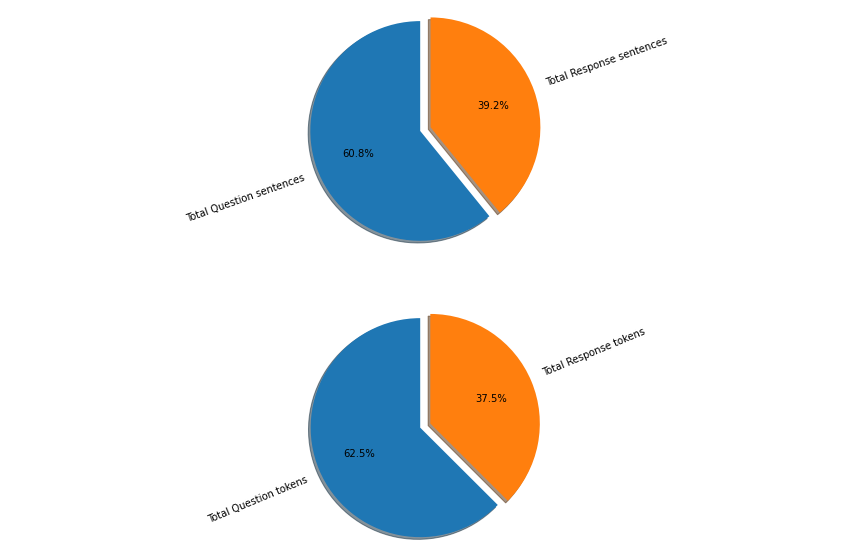

In [4]:
# Plot the total token and sentence counts.
# Reference: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

# Pie charts, where the slices will be ordered and plotted counter-clockwise:
labels_sentences = 'Total Question sentences', 'Total Response sentences'
labels_tokens = 'Total Question tokens', 'Total Response tokens'
sizes_sentences = [q_sentence_count, r_sentence_count]
sizes_tokens = [q_token_count, r_token_count]
explode = (0, 0.1) # Only explode the response counts

fig1, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
ax1.pie(
    sizes_sentences,
    explode=explode,
    labels=labels_sentences,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    rotatelabels=True
)
ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(
    sizes_tokens,
    explode=explode,
    labels=labels_tokens,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    rotatelabels=True
)
ax2.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

There are more sentences and tokens in the questions than in the responses. The congress-person generally needs to set the context before they can pose their question. This is the reason for the longer questions.

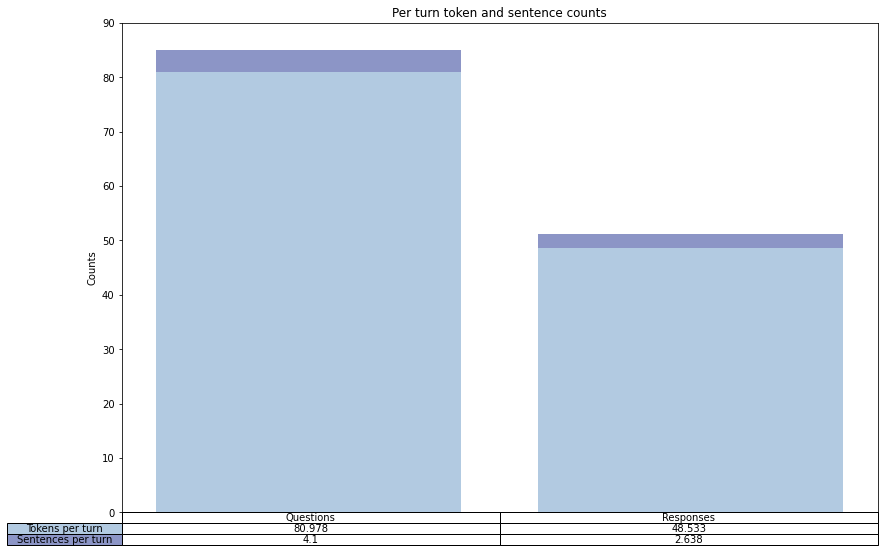

In [5]:
# Plot the per-turn token and sentence counts.
# Reference: https://matplotlib.org/stable/gallery/misc/table_demo.html

qr_per_turn_data = [
    [q_tokens_per_turn, r_tokens_per_turn],
    [q_sentences_per_turn, r_sentences_per_turn]
]

columns = ('Questions', 'Responses')
rows = ['Tokens per turn', 'Sentences per turn']

# Y-axis label values
values = np.arange(0, 100, 10)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0.3, 0.5, len(rows)))
n_rows = len(qr_per_turn_data)

index = np.arange(len(columns)) + 0.3

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []

for row in range(n_rows):
    plt.bar(x=index, height=qr_per_turn_data[row], bottom=y_offset, color=colors[row])
    y_offset = y_offset + qr_per_turn_data[row]
    cell_text.append([x for x in y_offset])

# Add a table at the bottom of the axes
the_table = plt.table(
    cellText=qr_per_turn_data,
    rowLabels=rows,
    rowColours=colors,
    colLabels=columns,
    cellLoc='center',
    rowLoc='center',
    colLoc='center',
    loc='bottom'
)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel('Counts')
plt.yticks(values, ['%d' % val for val in values])
plt.xticks([])
plt.title('Per turn token and sentence counts')

plt.show()

We have a larger amount of data in the questions than in the responses. It's more likely that we'll be able to find the cause of emotions in questions rather than responses.

In [6]:
# Calculate number of each sentiment labels per question type

q_total_sentiment_counts = {
    'neutral': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'attack': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'favor': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    }
}

for _, row in complete_data_with_duplicates.iterrows():
    q_total_sentiment_counts[row['gold_q_intent']][row['gold_q_sentiment']] += 1

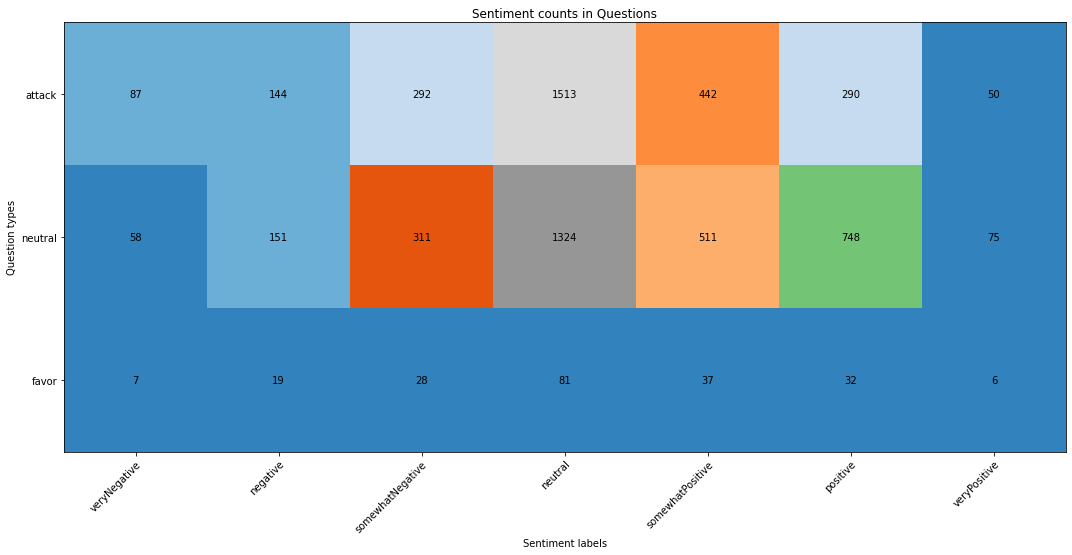

In [7]:
# Plot the per-question sentiment labels as a heatmap
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

question_types = ['attack', 'neutral', 'favor']
sentiment_labels = [
    'veryNegative',
    'negative',
    'somewhatNegative',
    'neutral',
    'somewhatPositive',
    'positive',
    'veryPositive'
]

# Convert the dictionary to a numpy array
q_sentiment_data = np.array([[q_total_sentiment_counts[question_type][sentiment_label] for sentiment_label in sentiment_labels] for question_type in question_types])

# Create a heatmap
fig, ax = plt.subplots()
im = ax.imshow(q_sentiment_data, cmap='tab20c')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(sentiment_labels)))
ax.set_xticklabels(sentiment_labels)
ax.set_yticks(np.arange(len(question_types)))
ax.set_yticklabels(question_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations.
for i in range(len(question_types)):
    for j in range(len(sentiment_labels)):
        text = ax.text(j, i, q_sentiment_data[i, j], ha='center', va='center', color='k')

ax.set_title('Sentiment counts in Questions')
plt.ylabel('Question types')
plt.xlabel('Sentiment labels')
fig.tight_layout()
plt.show()

There are very few questions that seem to favor the witness. Most 'attack' and 'neutral' questions don't show 'very positive' or 'very negative' sentiments. The sentiments for these questions are clustered more heavily around the 'central' sentiments. In other words, it's rarer for 'very negative' and 'very positive' sentiments to be shown. But it does seem to be trending towards 'very negative' for the 'attack' questions.

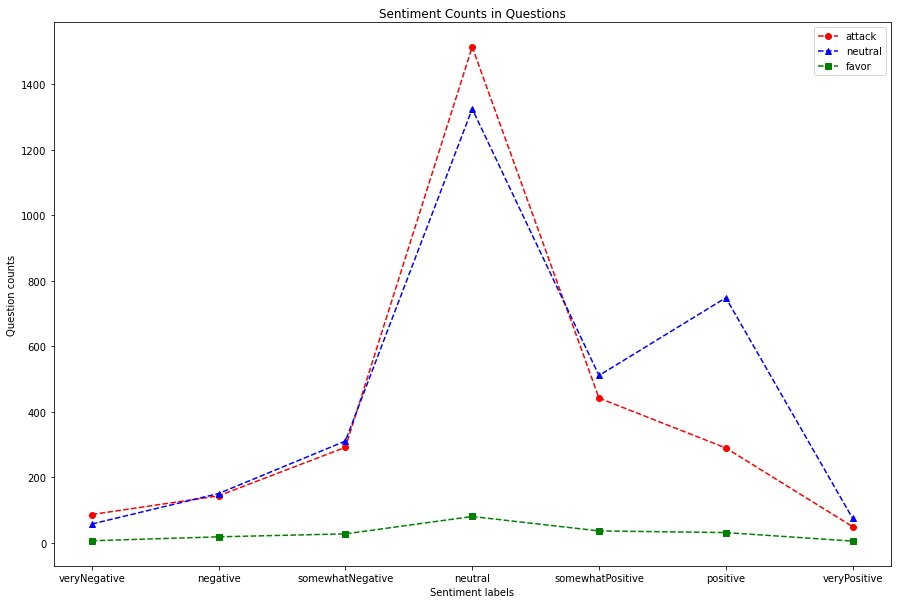

In [8]:
# Plot the per-sentiment question labels as a line curve

fig, ax = plt.subplots()

ax.plot(
    sentiment_labels,
    q_sentiment_data[0],
    label=question_types[0],
    color='red',
    marker='o',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    q_sentiment_data[1],
    label=question_types[1],
    color='blue',
    marker='^',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    q_sentiment_data[2],
    label=question_types[2],
    color='green',
    marker='s',
    linestyle='dashed'
)

ax.set_title('Sentiment Counts in Questions')
plt.ylabel('Question counts')
plt.xlabel('Sentiment labels')
plt.legend()

plt.show()

This line curve confirms the hypothesis that the question sentiment labels are generally Gaussian. The 'positive' sentiment for the 'neutral' questions is a bimodal distribution that is negatively skewed. It warrants two separate analyses.

In [9]:
# Calculate number of each sentiment labels per response type

r_total_sentiment_counts = {
    'answer': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'answer_overans-sway': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'shift-correct': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'shift-dodge': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'cant-answer-sincere': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    },
    'cant-answer-lying': {
        'veryNegative': 0,
        'negative': 0,
        'somewhatNegative': 0,
        'neutral': 0,
        'somewhatPositive': 0,
        'positive': 0,
        'veryPositive': 0
    }
}

for _, row in complete_data_with_duplicates.iterrows():
    r_total_sentiment_counts[row['gold_coarse_label']][row['gold_sentiment']] += 1

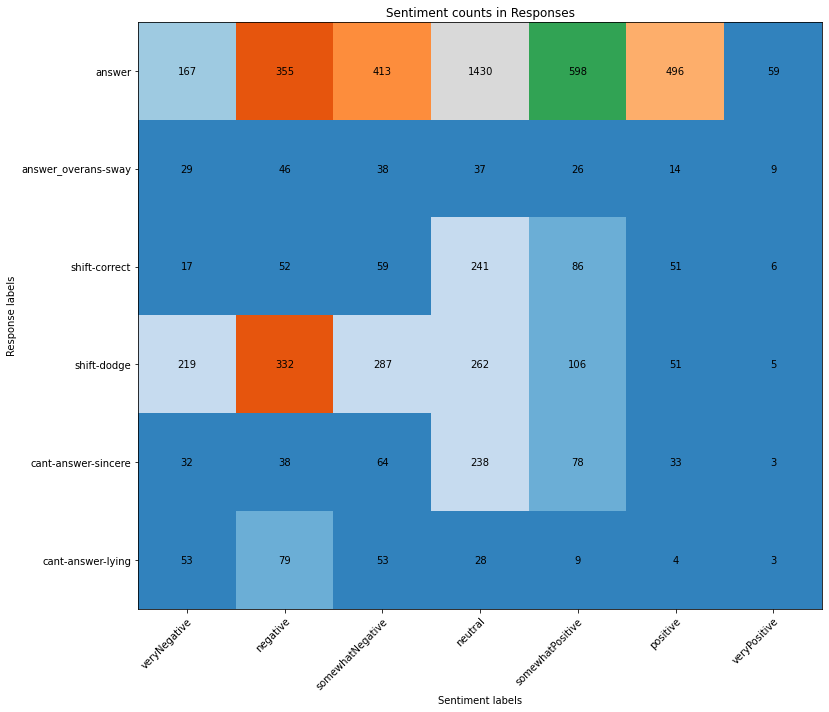

In [10]:
# Plot the per-response sentiment labels
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

response_labels = [
    'answer',
    'answer_overans-sway',
    'shift-correct',
    'shift-dodge',
    'cant-answer-sincere',
    'cant-answer-lying'
    
]

# Convert the dictionary to a numpy array
r_sentiment_data = np.array([[r_total_sentiment_counts[response_label][sentiment_label] for sentiment_label in sentiment_labels] for response_label in response_labels])

# Create a heatmap
fig, ax = plt.subplots()
im = ax.imshow(r_sentiment_data, cmap='tab20c')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(sentiment_labels)))
ax.set_xticklabels(sentiment_labels)
ax.set_yticks(np.arange(len(response_labels)))
ax.set_yticklabels(response_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations.
for i in range(len(response_labels)):
    for j in range(len(sentiment_labels)):
        text = ax.text(j, i, r_sentiment_data[i, j], ha='center', va='center', color='k')

ax.set_title('Sentiment counts in Responses')
plt.ylabel('Response labels')
plt.xlabel('Sentiment labels')
fig.tight_layout()
plt.show()

The 'direct answer' responses have a wide range of sentiments with a higher density in the 'center'. The 'shift dodge' responses seem to be positively skewed towards 'negative' sentiments, the similar to the 'can't answer lying' questions. The rest of the responses seem to be approximately Gaussian distributions.

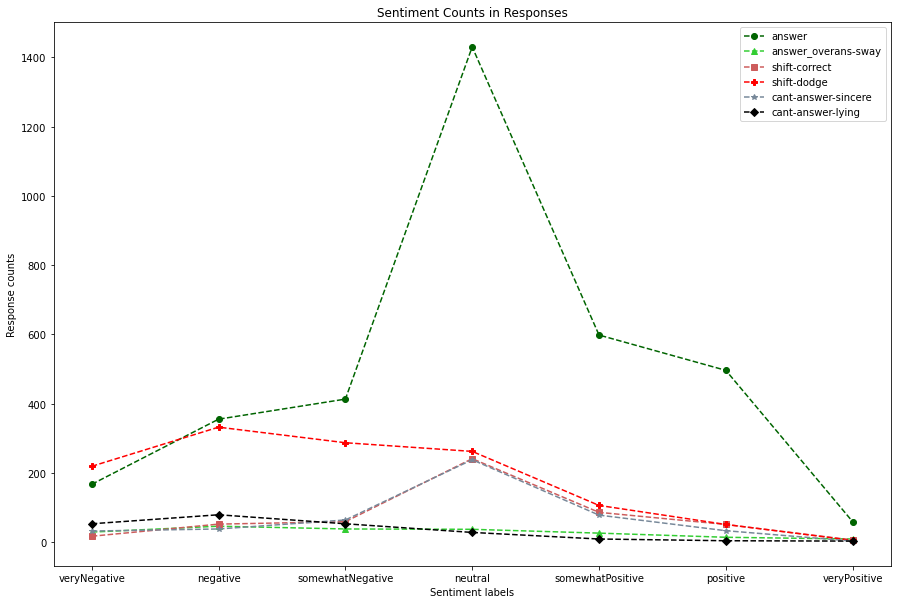

In [11]:
# Plot the per-sentiment response labels as a line curve

fig, ax = plt.subplots()

ax.plot(
    sentiment_labels,
    r_sentiment_data[0],
    label=response_labels[0],
    color='darkgreen',
    marker='o',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    r_sentiment_data[1],
    label=response_labels[1],
    color='limegreen',
    marker='^',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    r_sentiment_data[2],
    label=response_labels[2],
    color='indianred',
    marker='s',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    r_sentiment_data[3],
    label=response_labels[3],
    color='red',
    marker='P',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    r_sentiment_data[4],
    label=response_labels[4],
    color='lightslategray',
    marker='*',
    linestyle='dashed'
)
ax.plot(
    sentiment_labels,
    r_sentiment_data[5],
    label=response_labels[5],
    color='black',
    marker='D',
    linestyle='dashed'
)

ax.set_title('Sentiment Counts in Responses')
plt.ylabel('Response counts')
plt.xlabel('Sentiment labels')
plt.legend()

plt.show()

This line curve again confirms our hypotheses about the various types of responses.

In [12]:
# Calculate the emotion labels in each question-response pair
# using the text2emotion Python package

q_emotion_counts = {
    'neutral': {
        'Angry': 0,
        'Fear': 0,
        'Happy': 0,
        'Sad': 0,
        'Surprise': 0,
    },
    'attack': {
        'Angry': 0,
        'Fear': 0,
        'Happy': 0,
        'Sad': 0,
        'Surprise': 0,
    },
    'favor': {
        'Angry': 0,
        'Fear': 0,
        'Happy': 0,
        'Sad': 0,
        'Surprise': 0,
    }
}

q_intent_list = complete_data_without_duplicates['gold_q_intent'].tolist()

# Find the emotion expressed in the given text
def find_majority_emotion(text, intent_or_label):
    emotion_counts = t2e.get_emotion(text)
    
    majority_emotion_value = -1
    majority_emotion = 'Angry'

    for emotion in emotion_counts.keys():
        if emotion_counts[emotion] > majority_emotion_value:
            majority_emotion_value = emotion_counts[emotion]
            majority_emotion = emotion
    
    return (majority_emotion, intent_or_label)

# Use multiple processes to calculate the counts quickly
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    results = list(executor.map(find_majority_emotion, q_text_list, q_intent_list))

for q_emotion, q_intent in results:
    q_emotion_counts[q_intent][q_emotion] += 1

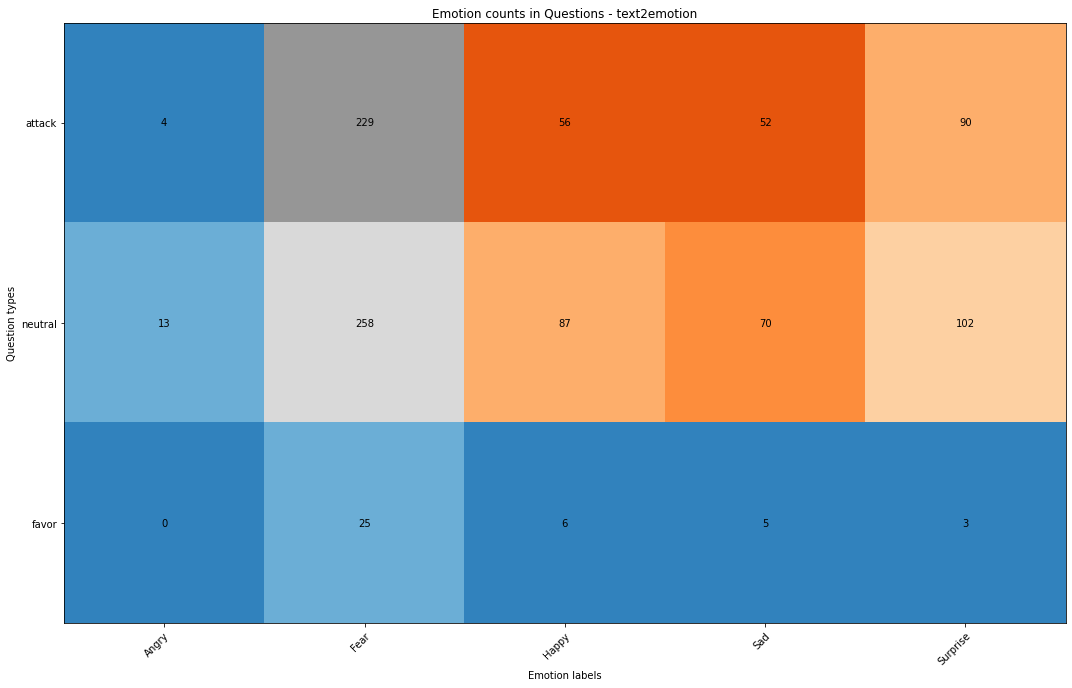

In [13]:
# Plot the per-question emotion labels as a heatmap
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

emotion_labels = list(sorted(q_emotion_counts['neutral'].keys()))

# Convert the dictionary to a numpy array
q_emotion_data = np.array([[q_emotion_counts[question_type][emotion_label] for emotion_label in emotion_labels] for question_type in question_types])

# Create a heatmap
fig, ax = plt.subplots()
im = ax.imshow(q_emotion_data, cmap='tab20c')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(emotion_labels)))
ax.set_xticklabels(emotion_labels)
ax.set_yticks(np.arange(len(question_types)))
ax.set_yticklabels(question_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations.
for i in range(len(question_types)):
    for j in range(len(emotion_labels)):
        text = ax.text(j, i, q_emotion_data[i, j], ha='center', va='center', color='k')

ax.set_title('Emotion counts in Questions - text2emotion')
plt.ylabel('Question types')
plt.xlabel('Emotion labels')
fig.tight_layout()
plt.show()

'Fear' is a dominant emotion in all question types. It's interesting to note that the 'Happy' and 'Sad' emotions, which can be considered to be on opposite sides of the emotion spectrum, have an equal distribution in the 'attack' and 'neutral' type questions.

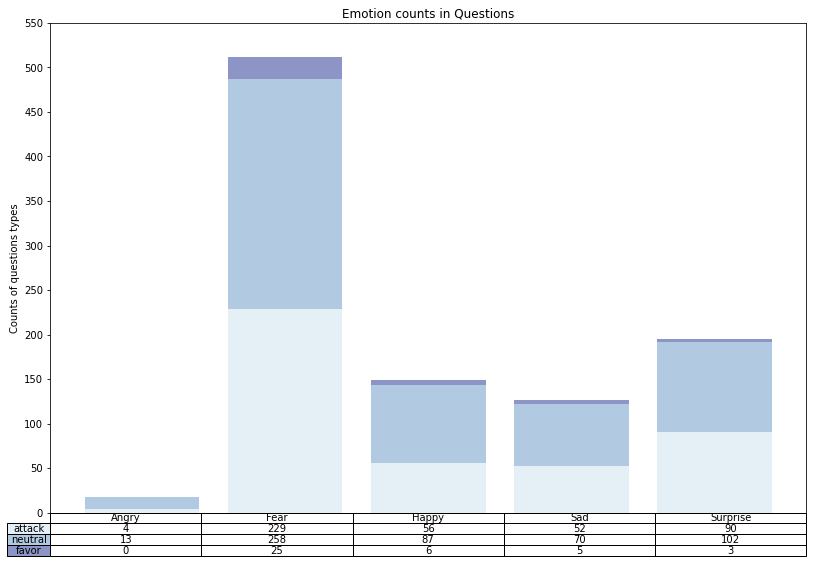

In [14]:
# Plot the per-emotion question labels as a bar chart with a table
# Reference: https://matplotlib.org/stable/gallery/misc/table_demo.html

# Y-axis label values
values = np.arange(0, 600, 50)

# Get some pastel shades for the colors
n_rows = len(question_types)
colors = plt.cm.BuPu(np.linspace(0.1, 0.5, n_rows))

index = np.arange(len(emotion_labels)) + 0.3

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(emotion_labels))

# Plot bars and create text labels for the table
cell_text = []

for row in range(n_rows):
    plt.bar(x=index, height=q_emotion_data[row], bottom=y_offset, color=colors[row])
    y_offset = y_offset + q_emotion_data[row]
    cell_text.append([x for x in y_offset])

# Add a table at the bottom of the axes
the_table = plt.table(
    cellText=q_emotion_data,
    rowLabels=question_types,
    rowColours=colors,
    colLabels=emotion_labels,
    cellLoc='center',
    rowLoc='center',
    colLoc='center',
    loc='bottom'
)

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel('Counts of questions types')
plt.yticks(values, ['%d' % val for val in values])
plt.xticks([])
plt.title('Emotion counts in Questions')

plt.show()

All the question types have a large amount of the 'Fear' emotion. There is a significant uptick of the 'Surprise' emotion for 'attack' and 'neutral' question types.

In [15]:
# Calculate the emotion labels in each question-response pair
# using a pre-trained RoBERTa model (that doesn't use emotion appraisal theory):
# https://huggingface.co/j-hartmann/emotion-english-roberta-large

q_emotion_counts = {
    'neutral': {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    },
    'attack': {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    },
    'favor': {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'neutral': 0,
        'sadness': 0,
        'surprise': 0
    }
}

q_df = pd.read_csv('../data/q_emotion_predictions.csv')

for _, row in q_df.iterrows():
    q_emotion, q_intent = row['label'], row['type']
    q_emotion_counts[q_intent][q_emotion] += 1

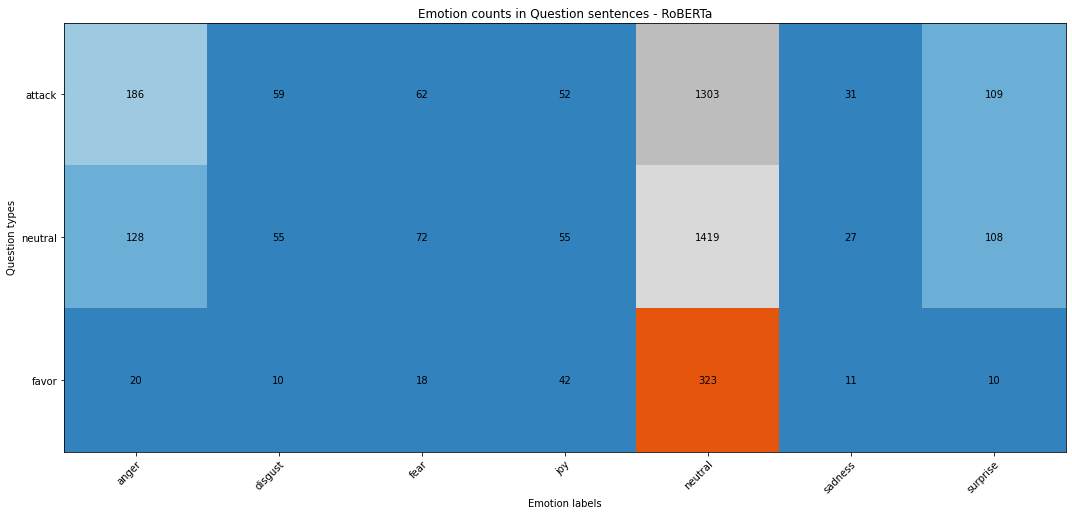

In [16]:
# Plot the per-question emotion labels as a heatmap
# Reference: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

emotion_labels = list(sorted(q_emotion_counts['neutral'].keys()))

# Convert the dictionary to a numpy array
q_emotion_data = np.array([[q_emotion_counts[question_type][emotion_label] for emotion_label in emotion_labels] for question_type in question_types])

# Create a heatmap
fig, ax = plt.subplots()
im = ax.imshow(q_emotion_data, cmap='tab20c')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(emotion_labels)))
ax.set_xticklabels(emotion_labels)
ax.set_yticks(np.arange(len(question_types)))
ax.set_yticklabels(question_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations.
for i in range(len(question_types)):
    for j in range(len(emotion_labels)):
        text = ax.text(j, i, q_emotion_data[i, j], ha='center', va='center', color='k')

ax.set_title('Emotion counts in Question sentences - RoBERTa')
plt.ylabel('Question types')
plt.xlabel('Emotion labels')
fig.tight_layout()
plt.show()

Question types that convey the "anger" and "surprise" emotion are higher for "attack" type question than for the other types. We hypothesize that an event or the response of the witness causes an increase in these emotions. Most of the question types are centered on the "neutral" label. As a U.S. Congressional Hearing is a publicized event, it makes intuitive sense that most statements are carefully worded in order to appear non-emotional.

# References

E. Ferracane, G. Durrett, J.J. Li, and K. Erk. 2021. Did they answer? subjective acts and intents in conversational discourse. In Proceedings of the 2021 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, pages 1626–1644, Online. Association for Computational Linguistics.

J. Vig. 2019. A Multiscale Visualization of Attention in the Transformer Model. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics: System Demonstrations, pages 37-42, Florence, Italy. Association for Computational Linguistics

Research Computing at the Rochester Institute of Technology. https://doi.org/10.34788/0S3G-QD15